## Head

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import sidetable
import datetime
import matplotlib.pyplot as plt
import functools

from typing import List, Union, Optional

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner



In [4]:
import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score

## Lib

In [5]:
import pylift_utils

In [6]:
def compute_receipts_features(
    receipts: pd.DataFrame,
    date_to: datetime.date,
    num_days: int,
) -> pd.DataFrame:
    date_to = datetime.datetime.combine(date_to, datetime.datetime.min.time())
    date_from = date_to - datetime.timedelta(days=num_days)
    date_mask = (receipts['transaction_datetime'] >= date_from) & (receipts['transaction_datetime'] < date_to)
    
    features = (
        receipts
        .loc[date_mask]
        .assign(points_spent=lambda d: d['regular_points_spent'] + d['express_points_spent'])
        .assign(points_spent_flag=lambda d: (d['points_spent'] < 0).astype(int))
        .assign(express_points_spent_flag=lambda d: (d['express_points_spent'] < 0).astype(int))
        .groupby(by=['client_id'])
        .agg({
            "transaction_id": "count",
            "purchase_sum": ["sum", "max", "min", "mean", "median"],
            "regular_points_spent": ["sum", "max"],
            "express_points_spent": ["sum", "max"],
            "transaction_datetime": ["min", "max"],
            "trn_sum_from_red": ["sum", "max", "mean"],
            "points_spent_flag": ["sum"],
            "express_points_spent_flag": ["sum"],
        })
        .assign(
            mean_time_interval=lambda d: (
                (d['transaction_datetime']['max'] - d['transaction_datetime']['min'])
                / (d['transaction_id']['count'] - 1)
            ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
        )
        .assign(
            time_since_last=lambda d: (
                date_to - d['transaction_datetime']['max']
            ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
        )
    )

    column_names = [
        f'rec__{col}__{agg}__{num_days}d' if agg else f'rec__{col}__{num_days}d'
        for col, agg in features.columns
    ]
    features.columns = column_names
    features.reset_index(inplace=True)

    return features

## Load'n'cook

### load

In [5]:
purchases = dd.read_parquet('data/purchases.parquet')

In [6]:
campaigns = pd.read_csv('data/campaigns.csv')

In [7]:
client_profile = pd.read_csv('data/client_profile.csv')

### first glance

In [10]:
purchases_head = purchases.head(1000)

In [11]:
purchases_head.head(20)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30531,1.0,77.0,NaN
1,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,668,1.0,70.0,NaN
2,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,15558,1.0,28.0,NaN
3,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,24637,1.0,57.0,NaN
4,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,31933,2.0,162.0,NaN
5,162,7921345,2018-12-06 13:24:59,1.8,0.0,0.0,0.0,368.00,560,30708,2.0,120.0,NaN
6,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30708,1.0,60.0,NaN
7,162,7556682,2018-12-17 11:56:33,0.7,0.0,0.0,0.0,140.00,472,31772,1.0,81.0,NaN
8,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,12790,0.0,63.0,NaN
9,162,7556682,2018-12-17 11:56:33,0.7,0.0,0.0,0.0,140.00,472,30708,1.0,60.0,NaN


In [12]:
purchases_head.stb.missing()

,missing,total,percent
trn_sum_from_red,968,1000,96.8
client_id,0,1000,0.0
transaction_id,0,1000,0.0
transaction_datetime,0,1000,0.0
regular_points_received,0,1000,0.0
express_points_received,0,1000,0.0
regular_points_spent,0,1000,0.0
express_points_spent,0,1000,0.0
purchase_sum,0,1000,0.0
store_id,0,1000,0.0


In [13]:
campaigns.head(20)

,client_id,treatment_flg,treatment_date,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,162,0,2019-03-21,195.00,1,0.0
1,359,1,2019-03-21,1298.93,3,300.0
2,600,1,2019-03-21,1224.17,1,-0.0
3,1042,1,2019-03-21,313.18,2,300.0
4,1080,1,2019-03-21,0.00,0,-0.0
5,1590,0,2019-03-21,1199.87,1,0.0
6,1607,1,2019-03-21,429.00,2,-0.0
7,1730,0,2019-03-21,414.89,3,0.0
8,1772,0,2019-03-21,1380.20,2,0.0
9,1812,1,2019-03-21,243.00,1,-0.0


In [14]:
campaigns['treatment_date'].value_counts()

2019-03-21    500000
Name: treatment_date, dtype: int64

In [15]:
campaigns['treatment_flg'].value_counts()

0    250018
1    249982
Name: treatment_flg, dtype: int64

In [16]:
campaigns.stb.missing()

,missing,total,percent
client_id,0,500000,0.0
treatment_flg,0,500000,0.0
treatment_date,0,500000,0.0
target_purchases_sum,0,500000,0.0
target_purchases_count,0,500000,0.0
target_campaign_points_spent,0,500000,0.0


In [17]:
client_profile.shape

(500000, 4)

In [18]:
client_profile.head(20)

,client_id,first_issue_date,age,gender
0,162,2018-07-06 19:36:04,52,F
1,359,2017-07-14 16:27:35,60,M
2,600,2017-10-10 12:22:44,82,M
3,1042,2017-11-26 11:21:29,40,U
4,1080,2018-02-21 19:08:56,21,U
5,1590,2017-06-05 20:45:37,58,M
6,1607,2017-05-19 17:27:57,80,F
7,1730,2017-09-14 16:26:14,69,U
8,1772,2017-07-13 18:56:30,31,U
9,1812,2018-09-27 12:47:29,67,F


In [19]:
client_profile.stb.missing()

,missing,total,percent
client_id,0,500000,0.0
first_issue_date,0,500000,0.0
age,0,500000,0.0
gender,0,500000,0.0


### cook

#### first features portion

In [ ]:
receipts = (
    purchases
    .groupby(by=['client_id', 'transaction_id'])
    .agg({
        'trn_sum_from_red': 'sum',
        'trn_sum_from_iss': 'sum',
        'regular_points_received': 'first',
        'express_points_received': 'first',
        'regular_points_spent': 'first',
        'express_points_spent': 'first',
        'purchase_sum': 'first',
        'store_id': 'first',
        'transaction_datetime': 'first',
    })
    .reset_index()
)

In [ ]:
receipts.to_parquet('data/receipts.parquet')

In [252]:
receipts = pd.read_parquet('data/receipts.parquet/')

In [147]:
FEATURES_DATE_TO = datetime.date(2019, 3, 19)


def _prepare_data(
    purchases: dd.DataFrame,
    receipts: pd.DataFrame,
    campaigns: pd.DataFrame,
    client_profile: pd.DataFrame,
    features_date_to: datetime.date = FEATURES_DATE_TO
) -> pd.DataFrame:
    
    result_parts = [
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=15),
        client_profile
    ]
    
    result = campaigns.copy()
    for part in result_parts:
        result = result.merge(part, on='client_id', how='left')  

    return result

In [144]:
data = _prepare_data(
    purchases,
    receipts,
    campaigns,
    client_profile
)

In [17]:
data.shape

(500000, 48)

#### profit from client

In [264]:
_columns = [
    'treatment_flg',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

data[_columns].head(5)

,treatment_flg,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,0,195.00,1,0.0
1,1,1298.93,3,300.0
2,1,1224.17,1,-0.0
3,1,313.18,2,300.0
4,1,0.00,0,-0.0


target_purchases_sum - сумма покупок клиента.

В нашем распоряжении нет данных о себестоимости товаров, поэтому **условимся**, что мы продаем все товары с коэффициентом **маржинальности 20%**

Знаем, что стоимость сообщения клиенту составляет 1.5 руб.

In [40]:
MARGIN_RATE = 0.2
POINTS_PER_RUBLE = 10.0
COMMUNICATION_COST = 1.5

In [ ]:
data = data.assign(target_profit=lambda d: (
    d['target_purchases_sum'] * MARGIN_RATE
    - d['target_campaign_points_spent'] / POINTS_PER_RUBLE
    - (d['treatment_flg'] == 1).astype(int) * COMMUNICATION_COST
))

In [265]:
_columns = [
    'treatment_flg',
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

data[_columns].head(20)

,treatment_flg,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,0,39.000,195.00,1,0.0
1,1,228.286,1298.93,3,300.0
2,1,243.334,1224.17,1,-0.0
3,1,31.136,313.18,2,300.0
4,1,-1.500,0.00,0,-0.0
5,0,239.974,1199.87,1,0.0
6,1,84.300,429.00,2,-0.0
7,0,82.978,414.89,3,0.0
8,0,276.040,1380.20,2,0.0
9,1,47.100,243.00,1,-0.0


#### historical visit probability

In [6]:
def _compute_historical_visit_probability(
    transaction_datetimes: pd.Series, period: int, date_to: datetime.date
) -> float:
    if len(transaction_datetimes) < 2:
        return 0.0
    dates = transaction_datetimes.dt.date.sort_values()
    diffs = (dates.iloc[1: ].reset_index(drop=True) - dates.iloc[: -1].reset_index(drop=True)).dt.days.values - period + 1
    diffs[np.where(diffs < 0)] = 0
    return 1.0 - diffs.sum() / ((date_to - dates.iloc[0]).days - period + 1)

In [360]:
receipts_sorted = receipts_.sort_values(by=['client_id', 'transaction_datetime'])

In [372]:
historical_visit_probability_7d = (
    receipts_sorted
    .groupby(by=['client_id'])
    ['transaction_datetime']
    .apply(functools.partial(_compute_historical_visit_probability, period=7, date_to=datetime.date(2019, 3, 20)))
)

invalid value encountered in long_scalars


In [193]:
historical_visit_probability_7d = pd.read_csv('data/wip/historical_visit_probability_7d.csv')

In [194]:
data = (
    data
    .merge(
        historical_visit_probability_7d
            .reset_index()
            .rename(columns={'transaction_datetime': 'historical_visit_probability__7d'}),
        on=['client_id'], how='left'
    )
)

### splits

In [23]:
fit_index, val_index = train_test_split(data.index, test_size=0.5, random_state=165)

### column sets

In [29]:
cols_features_n1 = [
    'rec__transaction_id__count__60d',
    'rec__purchase_sum__sum__60d',
    'rec__purchase_sum__max__60d',
    'rec__purchase_sum__min__60d',
    'rec__purchase_sum__mean__60d',
    'rec__purchase_sum__median__60d',
    'rec__regular_points_spent__sum__60d',
    'rec__regular_points_spent__max__60d',
    'rec__express_points_spent__sum__60d',
    'rec__express_points_spent__max__60d',
    'rec__trn_sum_from_red__sum__60d',
    'rec__trn_sum_from_red__max__60d',
    'rec__trn_sum_from_red__mean__60d',
    'rec__points_spent_flag__sum__60d',
    'rec__express_points_spent_flag__sum__60d',
    'rec__mean_time_interval__60d',
    'rec__time_since_last__60d',
    'age'
]

## Story

In [24]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])['target_profit'].mean()
_stats

treatment_flg
0    110.166496
1    109.370430
Name: target_profit, dtype: float64

In [26]:
_stats.loc[1] - _stats.loc[0]

-0.7960664261743347

### straightforward approach

#### build model

In [27]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [30]:
cols_features = cols_features_n1

In [31]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [32]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

#### evaluate model

In [33]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

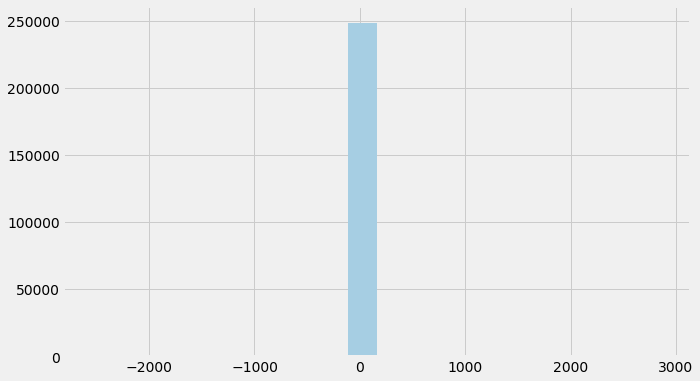

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

In [37]:
np.percentile(_eval_data['score'], 5)

-8.976226434063609

In [28]:
np.percentile(_eval_data['score'], 95)

5.553826622916524

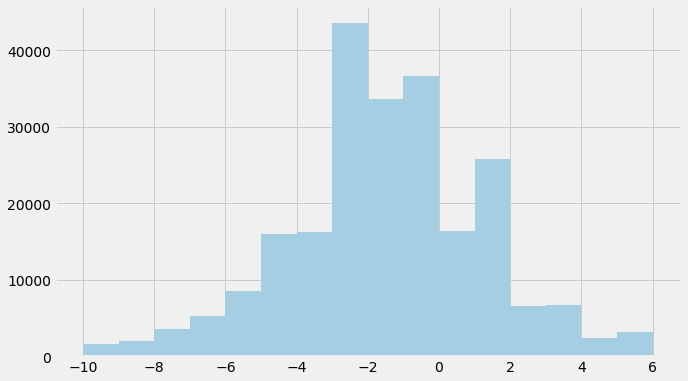

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(-10.0, 6.0), bins=16)
plt.show()

In [36]:
_eval_data['score'].describe()

count    250000.000000
mean         -1.200976
std          40.482959
min       -2542.436756
25%          -3.101358
50%          -1.365747
75%           0.643941
max        2861.336508
Name: score, dtype: float64

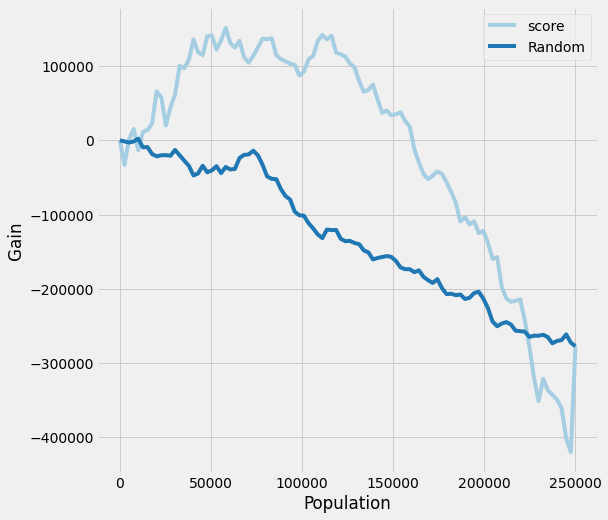

In [30]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

#### conclusions

Обратите вниемание, что
* uplift-кривая получается более "шумной", по сравнению с кейсами с предыдущих лекций
* (!) Уже есть вариант модели, который можно использовать в будущих кампаниях (prove of concept)


Но давайте попробуем построить более "простой" (возможно, не ML) подход

* Будет с чем сравнить текущее ML решение
* Решения без ML намного проще внедрить в production


##### cut

! Как интерпретировать получившуюся uplift-модель?

### first decomposition

Разложим CATE на слагаемые

<font size="5">
$$
Up[Y|X] = Up[Z|X] - P(R=1|X,T=1)b - c
$$
</font>

In [42]:
_target_columns = [
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

In [43]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])[_target_columns].mean()
_stats

,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
treatment_flg,,,,
0,110.166496,550.832481,1.333717,0.000000
1,109.370430,585.142188,1.444678,61.580077


In [49]:
print(
    'Up[Y] =',
    _stats.loc[1, 'target_profit'] - _stats.loc[0, 'target_profit']
)

Up[Y] = -0.7960664261743347


In [51]:
print(
    'Up[Z] =',
    MARGIN_RATE * (_stats.loc[1, 'target_purchases_sum'] - _stats.loc[0, 'target_purchases_sum'])
)

Up[Z] = 6.861941278394034


In [53]:
print(
    'P(R = 1|T = 1)b =',
    1 / POINTS_PER_RUBLE * (
        _stats.loc[1, 'target_campaign_points_spent'] - _stats.loc[0, 'target_campaign_points_spent']
    )
)

P(R = 1|T = 1)b = 6.1580077045674795


In [20]:
COMMUNICATION_COST

1.5

**Главные драйверы** ATE прибыли
* прирост маржи - $Up[Z]$
* затраты на баллы - $P(R = 1|T = 1)b$

<font size="4">   
    <b> Разложение </b> ожидаемого эффекта помогло <b>направить EDA</b>!
</font>

### points redemption

Попробуем прогнозировать

<font size="5">
$$P(R=1|X,T=1)$$
</font>

\- вероятность того, что клиент воспользуется бонусными баллами во время кампании (если их ему дать :) )

**Исходя из формулы**, понимаем, что для построения такой модели нужно **рассматривать** только **тех клиентов, которые получили предложение**

#### build redemption probability model

In [58]:
treated_fit_index = data.loc[fit_index, ['treatment_flg']].query('treatment_flg == 1').index

In [59]:
cols_features = cols_features_n1

In [60]:
red_p_model = lgb.LGBMRegressor()

In [61]:
red_p_model.fit(
    X=data.loc[treated_fit_index, cols_features],
    y=(data.loc[treated_fit_index, 'target_campaign_points_spent'] > 0).astype(int)
)

LGBMRegressor()

In [90]:
treated_val_index = data.loc[val_index, ['treatment_flg']].query('treatment_flg == 1').index

In [91]:
red_p_predictions = red_p_model.predict(data.loc[treated_val_index, cols_features])

In [93]:
pd.Series(red_p_predictions).describe()

count    125121.000000
mean          0.208238
std           0.122640
min          -0.139591
25%           0.120576
50%           0.182842
75%           0.265555
max           1.009483
dtype: float64

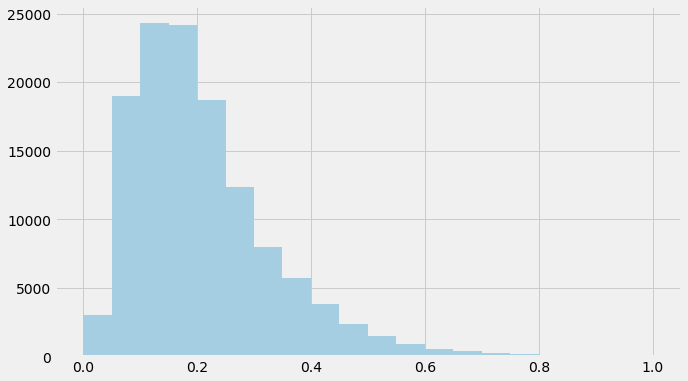

In [98]:
plt.figure(figsize=(10, 6))
plt.hist(red_p_predictions, range=(0.0, 1.0), bins=20)
plt.show()

In [94]:
roc_auc_score(
    (data.loc[treated_val_index, 'target_campaign_points_spent'] > 0).astype(int),
    red_p_predictions
)

0.6973884007001712

#### redemption probabilty (scores) VS profit uplift scores

In [99]:
cols_features = cols_features_n1

In [100]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [116]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target, 'target_campaign_points_spent']]
_eval_data['redemption_probabilty_score'] = -red_p_model.predict(_eval_data[cols_features])
_eval_data['profit_uplift_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data['target_campaign_points_spent_flg'] = (_eval_data['target_campaign_points_spent'] > 0).astype(int)
_eval_data = _eval_data.drop(columns=cols_features)

In [124]:
_eval_data['profit_uplift_score_bin'] = pd.qcut(_eval_data['profit_uplift_score'], q=8, duplicates='drop')

Посмотрим на вероятность списать баллы **в разрезе прогнозов uplift-модели** для прибыли.

BTW: Это хороший способ **интерпретации uplift-моделей**!

In [125]:
_pivot = _eval_data.loc[treated_val_index].groupby(by=['profit_uplift_score_bin']).agg(
    {'target_campaign_points_spent_flg': 'mean', 'profit_uplift_score_bin': 'count'}
)
_pivot

,target_campaign_points_spent_flg,profit_uplift_score_bin
profit_uplift_score_bin,,
"(-2542.438, -5.04]",0.304482,15574
"(-5.04, -3.101]",0.298541,15760
"(-3.101, -2.212]",0.235920,18697
"(-2.212, -1.366]",0.221562,12800
"(-1.366, -0.689]",0.167327,17421
"(-0.689, 0.644]",0.167510,13635
"(0.644, 1.726]",0.122886,15608
"(1.726, 2861.337]",0.156470,15626


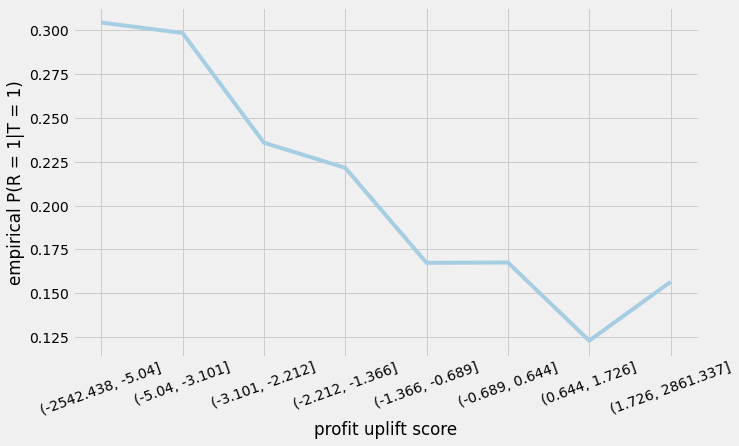

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(_pivot['target_campaign_points_spent_flg'])
plt.xticks(range(len(_pivot.index)), _pivot.index, rotation=20)
plt.xlabel('profit uplift score')
plt.ylabel('empirical P(R = 1|T = 1)')
plt.show()

Что, если отсортировать клиентов по прогнозу вероятности списать баллы?

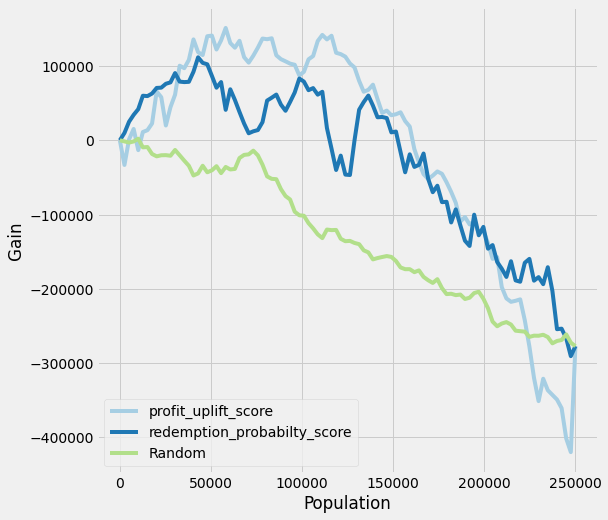

In [132]:
cmetrics.plot_gain(
    _eval_data[[col_treatment, col_target, 'profit_uplift_score', 'redemption_probabilty_score']],
    treatment_col=col_treatment,
    outcome_col=col_target,
)

### purchases sum uplift

Вспомним, что на уровне клиента

<font size="5">
$$
Z = QS
$$
</font>

Пример: клиент совершил 2 покупки в период кампании - на 500 и на 300 руб. В таком случае

Q = 2

S = (500 + 300) * MARGIN_RATE / 2 = 80 (руб.)
 

Посчитаем суммарные показатели Z, Q в разрезе по ЦГ и КГ.

На их основе высчитаем средний (на всю группу!) чек в разрезе по ЦГ и КГ.

In [138]:
_target_columns = [
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
]

In [139]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])[_target_columns].mean()
_stats['target_average_check'] = _stats['target_purchases_sum'] / _stats['target_purchases_count']
_stats

,target_profit,target_purchases_sum,target_purchases_count,target_average_check
treatment_flg,,,,
0,110.166496,550.832481,1.333717,413.005548
1,109.370430,585.142188,1.444678,405.032812


In [67]:
MARGIN_RATE * (_stats.loc[1, 'target_purchases_sum'] - _stats.loc[0, 'target_purchases_sum'])

6.861941278394034

In [68]:
_stats.loc[1, 'target_purchases_sum'] / _stats.loc[0, 'target_purchases_sum']

1.0622870065862924

In [69]:
_stats.loc[1, 'target_purchases_count'] / _stats.loc[0, 'target_purchases_count']

1.083197247562177

In [70]:
_stats.loc[1, 'target_average_check'] / _stats.loc[0, 'target_average_check']

0.9806958141530133

Кажется, что выручка меняется **сильнее** от того, что **клиенты чаще ходят в магазин**, нежели от падения среднего чека

Теперь выпишем строгую формулировку разложения

<font size="5">
$$
Up[Z|X] = E[\delta_Q S(0)|X] + E[Q(0) \delta_{S}|X] + E[\delta_Q \delta_{S}|X]
$$
</font>

где 

$Q(1)$, $Q(0)$ - количество покупок клиента в период кампании во вселенной с оффером и без оффера соответственно,

$ \delta_Q = Q(1) - Q(0)$,

$S(1)$, $S(0)$ - средняя маржа (в руб.) покупок клиента в период кампании во вселенной с оффером и без оффера соответственно,

$ \delta_S = S(1) - S(0)$.


Исходя из почитанных ранее чисел, предполагаем, что **главным** слагаемым является 
<font size="4">
$E[\delta_Q S(0)|X]$
</font>

Удостоверимся, что величины $\delta_Q$ и $S(0)$ сильно связаны с прогнозом uplift прибыли.

Сделаем это, рассмотрев показатели в разрезе прогнозов uplift-модели

In [140]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'target_purchases_sum', 'target_purchases_count']]
_eval_data['profit_uplift_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[[
    'target_purchases_sum', 'profit_uplift_score', 'target_purchases_count',
    col_treatment
]]

In [141]:
_eval_data['profit_uplift_score_bin'] = pd.qcut(_eval_data['profit_uplift_score'], q=8, duplicates='drop')

In [175]:
_stats = (
    _eval_data
    .assign(target_margin_sum=lambda d: d['target_purchases_sum'] * MARGIN_RATE)
    .pivot_table(
        index=['profit_uplift_score_bin'],
        columns=[col_treatment],
        values=['target_purchases_sum', 'target_purchases_count', 'target_margin_sum']
    )
)

_stats.loc[:, ('target_margin_per_purchase', 0)] = _stats['target_margin_sum'][0] / _stats['target_purchases_count'][0]
_stats.loc[:, ('target_margin_per_purchase', 1)] = _stats['target_margin_sum'][1] / _stats['target_purchases_count'][1]
_stats['margin_per_purchase_uplift'] = _stats['target_margin_per_purchase'][1] - _stats['target_margin_per_purchase'][0]

_stats['purchases_count_uplift'] = _stats['target_purchases_count'][1] - _stats['target_purchases_count'][0]
_stats['purchases_sum_uplift'] = _stats['target_purchases_sum'][1] - _stats['target_purchases_sum'][0]
_stats['purchases_count_perc_uplift'] = _stats['target_purchases_count'][1] / _stats['target_purchases_count'][0]
_stats['purchases_sum_perc_uplift'] = _stats['target_purchases_sum'][1] / _stats['target_purchases_sum'][0]
_stats

target_margin_sum             target_purchases_count  \
treatment_flg                           0           1                      0   
profit_uplift_score_bin                                                        
(-2542.438, -5.04]             222.288401  231.891224               2.542474   
(-5.04, -3.101]                113.629201  120.104469               1.995257   
(-3.101, -2.212]                82.196175   87.138411               1.325139   
(-2.212, -1.366]                94.839480   99.840130               1.296370   
(-1.366, -0.689]                63.603688   69.638819               0.823596   
(-0.689, 0.644]                 84.263016   89.868870               0.958466   
(0.644, 1.726]                  65.585811   72.879707               0.622526   
(1.726, 2861.337]              163.174766  171.437591               1.137416   

                                  target_purchases_sum               \
treatment_flg                   1                    0            1   
profit_uplift_score_bin                                               
(-2542.438, -5.04]       2.651085          1111.442006  1159.456120   
(-5.04, -3.101]          2.168147           568.146004   600.522347   
(-3.101, -2.212]         1.458041           410.980877   435.692056   
(-2.212, -1.366]         1.410156           474.197402   499.200648   
(-1.366, -0.689]         0.927157           318.018438   348.194094   
(-0.689, 0.644]          1.038871           421.315079   449.344350   
(0.644, 1.726]           0.711879           327.929054   364.398533   
(1.726, 2861.337]        1.201139           815.873831   857.187955   

                        target_margin_per_purchase              \
treatment_flg                                    0           1   
profit_uplift_score_bin                                          
(-2542.438, -5.04]                       87.429944   87.470304   
(-5.04, -3.101]                          56.949665   55.394979   
(-3.101, -2.212]                         62.028325   59.764017   
(-2.212, -1.366]                         73.157707   70.800757   
(-1.366, -0.689]                         77.226785   75.110071   
(-0.689, 0.644]                          87.914435   86.506321   
(0.644, 1.726]                          105.354274  102.376605   
(1.726, 2861.337]                       143.460958  142.729170   

                        margin_per_purchase_uplift purchases_count_uplift  \
treatment_flg                                                               
profit_uplift_score_bin                                                     
(-2542.438, -5.04]                        0.040361               0.108611   
(-5.04, -3.101]                          -1.554686               0.172890   
(-3.101, -2.212]                         -2.264308               0.132902   
(-2.212, -1.366]                         -2.356951               0.113786   
(-1.366, -0.689]                         -2.116715               0.103561   
(-0.689, 0.644]                          -1.408114               0.080404   
(0.644, 1.726]                           -2.977668               0.089352   
(1.726, 2861.337]                        -0.731788               0.063723   

                        purchases_sum_uplift purchases_count_perc_uplift  \
treatment_flg                                                              
profit_uplift_score_bin                                                    
(-2542.438, -5.04]                 48.014115                    1.042718   
(-5.04, -3.101]                    32.376343                    1.086651   
(-3.101, -2.212]                   24.711179                    1.100293   
(-2.212, -1.366]                   25.003245                    1.087773   
(-1.366, -0.689]                   30.175657                    1.125742   
(-0.689, 0.644]                    28.029271                    1.083889   
(0.644, 1.726]                     36.469480                    1.143532   
(1.726, 2861.337]         

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


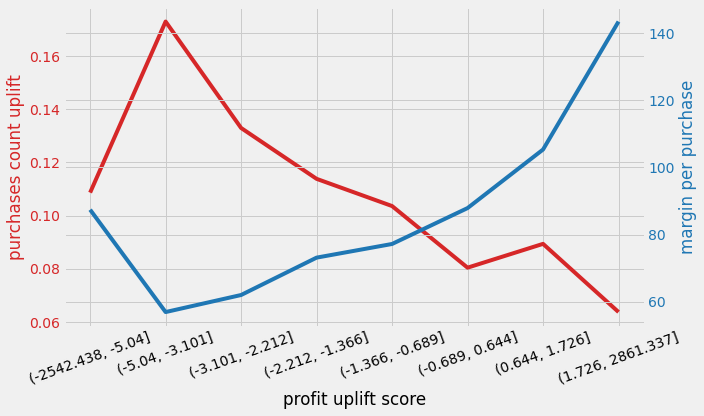

In [165]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('profit uplift score')
ax1.set_ylabel('purchases count uplift', color=color)
ax1.plot(_stats['purchases_count_uplift'], color=color)
plt.xticks(range(len(_stats.index)), _stats.index, rotation=20)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('margin per purchase', color=color)
ax2.plot(_stats['target_margin_per_purchase'][0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

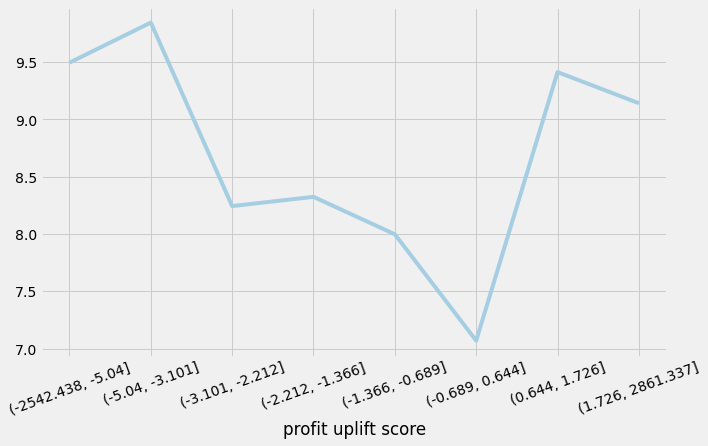

In [204]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('profit uplift score')
ax1.plot(
    (
        _stats['purchases_count_uplift'] * _stats['target_margin_per_purchase'][0]
    )
)
plt.xticks(range(len(_stats.index)), _stats.index, rotation=20)

plt.show()

### rough model

Давайте используем все полученные ранее выводы, чтобы построить грубую схему прогноза

Мы пришли к такой формуле разложения CATE "прибыли"

<font size="4">
$$
Up[Y|X] = (E[\delta_Q S(0)|X] + E[Q(0) \delta_{S}|X] + E[\delta_Q \delta_{S}|X]) - P(R=1|X, T = 1)b - c
$$
</font>

Если пренебречь теми слагаемыми, которые кажутся нам "малыми", получим

<font size="4">
$$
\hat{Up}[Y|X] \sim \hat{E}[\delta_Q S(0)|X] - \hat{P}(R=1|X, T = 1)b - c
$$
</font>

Как можно спрогнозировать $\hat{E}[\delta_Q S(0)|X]$?

Давайте попробуем

$$
\hat{E}[\delta_Q S(0)|X] \sim \hat{E}[S(0)|X] \hat{Up}[Q]
$$

где

$\hat{Up}[Q]$ - средний по больнице прирост числа чеков на клиента,

$\hat{E}[S(0)|X]$ - оценка средней прибыли с чека клиента. Можно
* использовать ML
* или, к примеру, взять **среднюю маржу с его покупок** за длинный предшествующий кампании период времени (60 дней)

In [180]:
tmp = data.loc[fit_index].pivot_table(
    values=['target_purchases_count', 'target_purchases_sum'],
    index=[col_treatment]
)
tmp['target_margin_per_purchase'] = MARGIN_RATE * tmp['target_purchases_sum'] / tmp['target_purchases_count']
tmp

,target_purchases_count,target_purchases_sum,target_margin_per_purchase
treatment_flg,,,
0,1.333717,550.832481,82.601110
1,1.444678,585.142188,81.006562


In [186]:
purchases_count_uplift = tmp.loc[1, 'target_purchases_count'] - tmp.loc[0, 'target_purchases_count']

In [233]:
print('Estimate of Up[Q] =', purchases_count_uplift)

Estimate of Up[Q] = 0.11096157567287057


Как можно спрогнозировать $\hat{P}(R = 1|X, T = 1)$?

Заметим, что
   
$$P(R = 1|X, T = 1) = P(R = 1|X, T = 1, Z > 0) P(Z > 0|X, T = 1)$$

Давайте попробуем

$$
\hat{P}(R=1|X, T = 1) \sim \hat{P}(R=1|T = 1, Z > 0) \hat{P}(Z > 0|X, T = 1)
$$

где

$\hat{P}(R=1|T = 1, Z > 0)$ - средняя "по больнице" вероятность списать полученные баллы, при условии, что клиент совершал покупки.

$ \hat{P}(Z > 0|X, T = 1)$ - оценка вероятности того, что клиент совершит покупку в период кампании. Можно 
* использовать ML
* или, к примеру,  взять **долю окон в 7 дней (длительность кампании), в которые клиент совершал покупку**.


In [188]:
treatment_index = data.query(f'{col_treatment} == 1').index
p_redeem_if_buy_rate = (
    (data.loc[treatment_index]['target_campaign_points_spent'] > 0).astype(int).sum()
    / (data.loc[treatment_index]['target_purchases_count'] > 0).astype(int).sum()
)


In [237]:
print('Estimate of P(R=1|T=1,Z>0) =', p_redeem_if_buy_rate)

Estimate of P(R=1|T=1,Z>0) = 0.3259764004068465


Соберем итоговый прогноз по формуле

<font size="4">
$$
\hat{Up}[Z|X] \sim \hat{E}[S(0)|X] \hat{Up}[Q] - \hat{P}(R=1|T = 1, Z > 0) \hat{P}(Z > 0|X, T = 1) - c
$$
</font>

In [251]:
data[['historical_visit_probability__7d', 'rec__purchase_sum__mean__60d']].stb.missing()

,missing,total,percent
historical_visit_probability__7d,166,500000,0.0332
rec__purchase_sum__mean__60d,0,500000,0.0000


In [267]:
BENEFIT_RUB = 30.0
prediction = (
    purchases_count_uplift * MARGIN_RATE * data['rec__purchase_sum__mean__60d']
    - data['historical_visit_probability__7d'].fillna(1.0) * p_redeem_if_buy_rate * BENEFIT_RUB
    - COMMUNICATION_COST
)

In [255]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['model_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data['rough_score'] = prediction.loc[val_index]
_eval_data = _eval_data[['model_score', 'rough_score', col_treatment, col_target]]

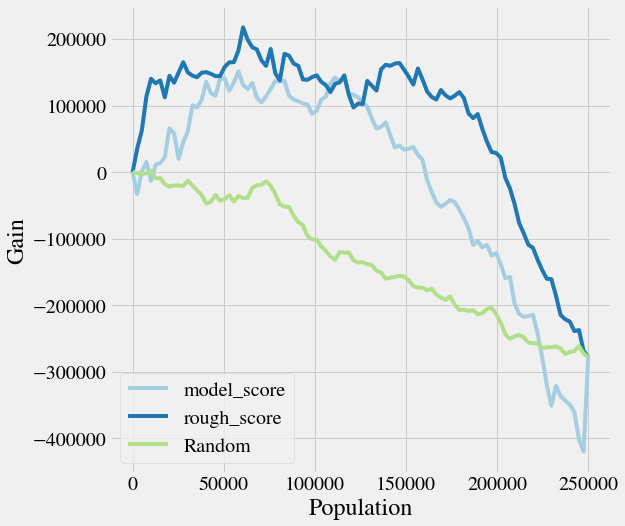

In [256]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

Если текущий вариант модели не лучше прогноза по грубой формуле, то нужно 
* либо плотнее заняться улучшением модели
* либо пользоваться прогнозом по грубой формуле



Большой минус грубых подходов - **плохая адаптируемость к изменениям** в среде.Если со временем бОльшую роль в эффекте станут играть другие слагаемые, то такой подход не подстроится к изменению.

**Потребуется ручная работа аналитика** для вывода новых главных факторов

In [260]:
_eval_data[['model_score', 'rough_score']].describe()

,model_score,rough_score
count,250000.000000,250000.000000
mean,-1.200976,3.375115
std,40.482959,9.472101
min,-2542.436756,-10.986353
25%,-3.101358,-2.617431
50%,-1.365747,1.143984
75%,0.643941,6.611140
max,2861.336508,387.180411


In [257]:
upeval = pylift.eval.UpliftEval(
    treatment=_eval_data[col_treatment],
    outcome=_eval_data[col_target],
    prediction=_eval_data['rough_score'],
    n_bins=10
)

No handles with labels found to put in legend.


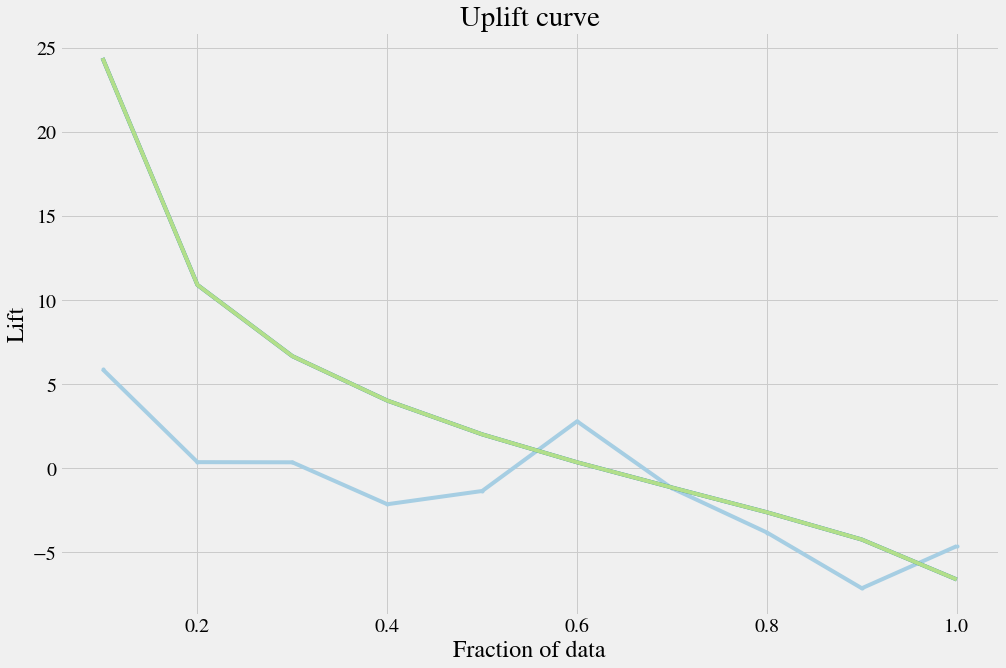

In [258]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))

Оценка получилась **смещенной** - как и ожидалось, ведь мы ввели не совсем корректные упрощения в формулу.

In [245]:
upeval = pylift.eval.UpliftEval(
    treatment=_eval_data[col_treatment],
    outcome=_eval_data[col_target],
    prediction=_eval_data['model_score'],
    n_bins=10
)

No handles with labels found to put in legend.


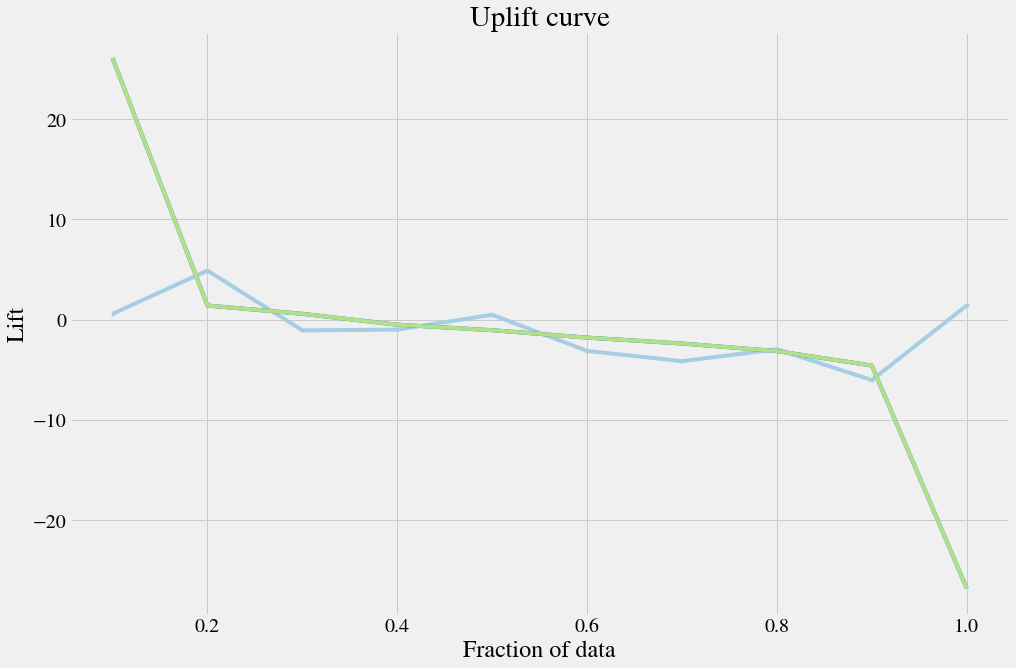

In [246]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))